## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional, Dict, Any
from metric_tests import run_tests
%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре. 

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [2]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [3]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
2889439,351131,9728,105,1070,16.0
2000066,364564,4151,38,13305,88.0
4203377,941786,4151,44,1036,13.0
2406379,250216,10994,100,15136,100.0
474670,878091,12192,159,14,0.0


Сделаем разбиение по времени

<Axes: >

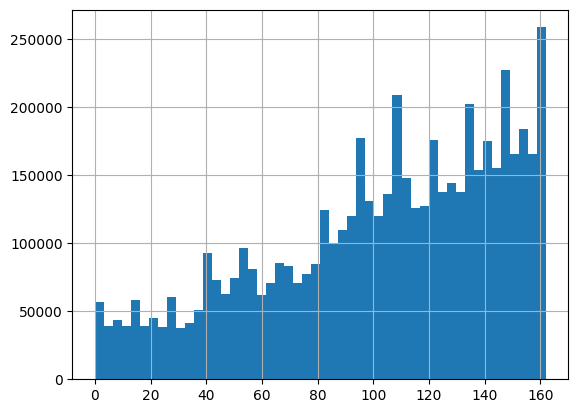

In [4]:
df.last_watch_dt.hist(bins=50)

In [5]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [6]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [7]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [8]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
128,302831,15735,127,2887,13.0
333,384509,1048,77,1027,16.0
349,622633,6957,140,1407,2.0
380,1027701,6638,124,170,2.0
381,888917,14684,131,723,16.0


In [9]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

,user_id,train_interactions
0,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ..."
1,400,"[(169, 144), (11047, 145), (12974, 145), (1399..."
2,414,"[(10440, 152), (2940, 152)]"
3,415,"[(3734, 105), (7571, 108), (8442, 110), (4457,..."
4,467,"[(8077, 21), (7134, 27), (10183, 30), (13955, ..."


In [10]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ...","[(11047, 153)]"
1,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]"
2,414,"[(10440, 152), (2940, 152)]","[(10100, 153), (4143, 153), (9873, 153), (142,..."
3,415,"[(3734, 105), (7571, 108), (8442, 110), (4457,...","[(12527, 154), (5330, 162), (16152, 162), (103..."
4,467,"[(8077, 21), (7134, 27), (10183, 30), (13955, ...","[(5940, 155), (11155, 159), (3777, 160), (575,..."


In [11]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ...","[(11047, 153)]","[16498, 6922, 14112]"
1,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[16498, 6922, 14112]"
2,414,"[(10440, 152), (2940, 152)]","[(10100, 153), (4143, 153), (9873, 153), (142,...","[16498, 6922, 14112]"
3,415,"[(3734, 105), (7571, 108), (8442, 110), (4457,...","[(12527, 154), (5330, 162), (16152, 162), (103...","[16498, 6922, 14112]"
4,467,"[(8077, 21), (7134, 27), (10183, 30), (13955, ...","[(5940, 155), (11155, 159), (3777, 160), (575,...","[16498, 6922, 14112]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$. 

In [12]:
def ap_metric(
        gt_items: List[int],
        predictions: List[int],
        topn: Optional[int] = None
):
    if topn is None:
        topn = len(predictions)

    denom = min(topn, len(gt_items))
    if denom == 0:
        denom = 1

    mltp = 1 / denom
    flags = np.isin(predictions[:topn], gt_items).astype(int)
    p_i = np.cumsum(flags) / (np.arange(len(flags)) + 1)
    result = mltp * np.sum(flags * p_i)
    return result


def rr_metric(
        gt_items: List[int],
        predictions: List[int],
        topn: Optional[int] = None
):
    if topn is None:
        topn = len(predictions)
    flags = np.isin(predictions[:topn], gt_items).astype(int)
    relevant_items = np.where(flags == 1)
    if len(relevant_items) == 0 or len(relevant_items[0]) == 0:
        return 0
    return 1 / (relevant_items[0][0] + 1)


def hr_metric(
        gt_items: List[int],
        predictions: List[int],
        topn: Optional[int] = None
):
    if topn is None:
        topn = len(predictions)
    flags = np.isin(predictions[:topn], gt_items).astype(int)
    return int(np.any(flags == 1))


Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит. 

In [ ]:
run_tests(ap_metric, rr_metric, hr_metric)


В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать. 

In [16]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [19]:
# делал на линукс + винде, на винде без printoptions была точность до 1 знака после запятой)
np.set_printoptions(precision=5)
evaluate_recommender(joined, model_preds='random_recs')


{'map': 0.0001333333333333333, 'mrr': 0.0002, 'hr': 0.0002}

In [21]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ...","[(11047, 153)]","[16498, 6922, 14112]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
1,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[16498, 6922, 14112]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
2,414,"[(10440, 152), (2940, 152)]","[(10100, 153), (4143, 153), (9873, 153), (142,...","[16498, 6922, 14112]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
3,415,"[(3734, 105), (7571, 108), (8442, 110), (4457,...","[(12527, 154), (5330, 162), (16152, 162), (103...","[16498, 6922, 14112]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
4,467,"[(8077, 21), (7134, 27), (10183, 30), (13955, ...","[(5940, 155), (11155, 159), (3777, 160), (575,...","[16498, 6922, 14112]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [22]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06570008060909549, 'mrr': 0.11914634920634921, 'hr': 0.2736}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [23]:
class TopPopularWeighted(TopPopular):

    def __init__(self, max_dt=0, min_window=2):
        super().__init__()
        self.min_window = min_window
        self.max_dt = max_dt

    def fit(self, df, col='train_interactions', time_window=30):
        counts = {}
        time_threshold = self.max_dt - time_window
        time_threshold = max(time_threshold, 1)
        
        for _, row in df.iterrows():
            for item, dt in row[col]:
                if dt >= time_threshold:
                    if item in counts:
                        counts[item] += 1
                    else:
                        counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10) -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]] * len(df)

In [24]:
def evaluate_recommender_abs(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'ap': np.sum([x[0] for x in metric_values]),
            'rr': np.sum([x[1] for x in metric_values]),
            'hr': np.sum([x[2] for x in metric_values])}

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна. 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

max_dt = df.last_watch_dt.max()
results = []
for window in range(1, 100, 10):
    top_pop_w = TopPopularWeighted(max_dt=max_dt, min_window=5)
    top_pop_w.fit(joined, time_window=window)
    col_name = f"toppW_recs@{window}"
    joined[col_name] = top_pop_w.predict(joined)
    metrics = evaluate_recommender_abs(joined, model_preds=col_name)
    results.append({"window": window, **metrics})

results_df = pd.DataFrame(results)

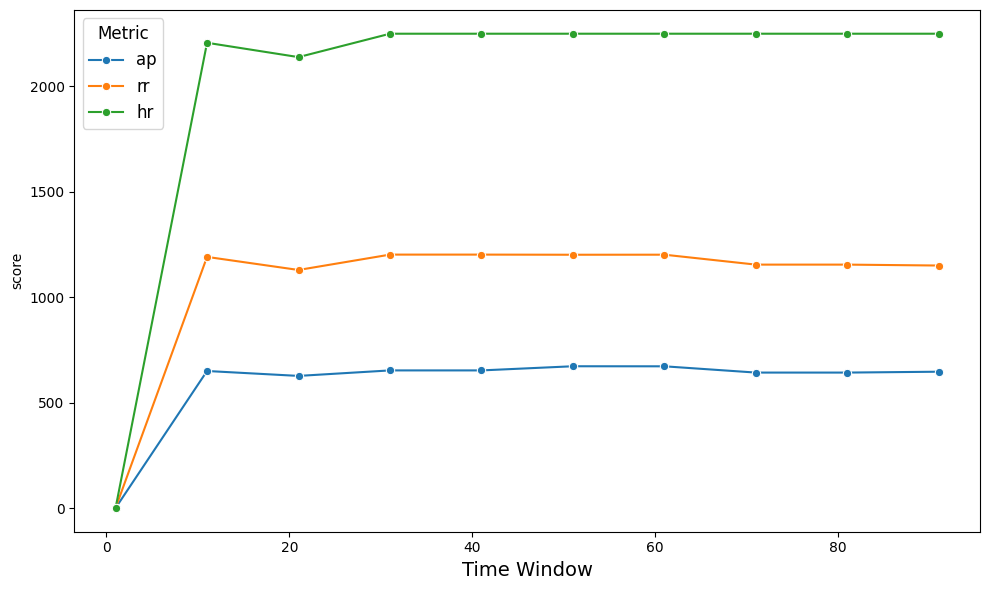

In [ ]:
melted_df = results_df.melt(id_vars=["window"], value_vars=["ap", "rr", "hr"], 
                            var_name="metric", value_name="score")


plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_df, x="window", y="score", hue="metric", marker="o")
plt.xlabel("Time Window", fontsize=14)
plt.legend(title="Metric", title_fontsize=12, fontsize=12)
plt.tight_layout()
plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:**
 При маленьком окне  качество рекомендаций очень плохое, так как такого маленького промежутка времени не хватает для определения наиболее популярных элементов.Далее, с увеличением времени становится понятнее, какие именно айтемы имеют наибольшую популярность и метрики выходят на асимптоту. Однако впоследствие, с увеличением окна, айтемы, которые были популярны, начинают постепенно устаревать что сказывается на метриках. 

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике. 

In [ ]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

In [ ]:
max_dt = df.last_watch_dt.max()
results = []
for window in range(1, 101, 1):
    top_pop_w = TopPopularWeighted(max_dt=max_dt, min_window=5)
    top_pop_w.fit(joined, time_window=window)
    col_name = f"toppW_recs@{window}"
    joined[col_name] = top_pop_w.predict(joined)
    metrics = evaluate_recommender(joined, model_preds=col_name)
    results.append({"window": window, **metrics})

results_df = pd.DataFrame(results)



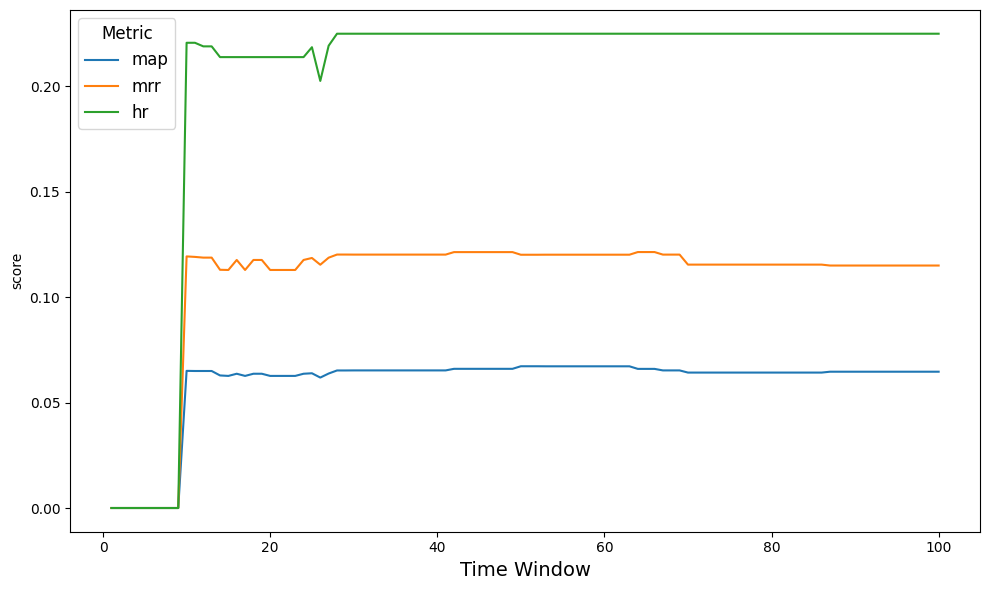

In [ ]:
melted_df = results_df.melt(id_vars=["window"], value_vars=["map", "mrr", "hr"], 
                            var_name="metric", value_name="score")


plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_df, x="window", y="score", hue="metric")
plt.xlabel("Time Window", fontsize=14)
plt.legend(title="Metric", title_fontsize=12, fontsize=12)
plt.tight_layout()
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:**
Все три метрики монотонны по top-K.
- HR@K: Чем больше K, тем выше вероятность, что хотя бы один релевантный элемент попадёт в рекомендации
- MRR@K: Если релевантный элемент уже найден на меньшем K, увеличение K только улучшит результат
- MAP@K: Метрика учитывает точность на каждом шаге. При увеличении K она может расти, выходит на асимптоту когда все релевантные айтемы были найдены

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:**
- MAP@K: Показывает, насколько релевантные элементы сконцентрированы в верхней части списка. Высокий MAP означает, что пользователь, скролля ленту, быстрее находит полезные рекомендации
- MRR@K: Важна для сценариев, где пользователь ищет что-то конкретное (например, товар или информацию). Чем выше MRR, тем быстрее он находит нужный результат
- HR@K: Показывает, есть ли в рекомендациях хотя бы один релевантный элемент. Это важно для лент новостей или рекомендаций, где пользователь не обязательно просматривает весь список.

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:**

**MAP и MRR**: Растут медленно, так как при увеличении K добавляются нерелевантные элементы, снижая точность. Релевантные элементы в конце списка вносят меньший вклад
**HR**: Растёт быстрее, так как учитывает только наличие релевантных элементов, а не их порядок
Поведение метрик зависит от их структуры: MAP и MRR чувствительны к порядку и точности, а HR — только к наличию релевантных элементов.

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей. 

In [27]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

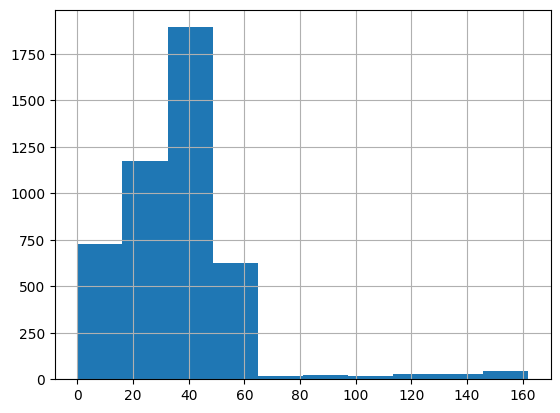

In [28]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

In [53]:
df

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,59,4250,72.0
1,699317,1659,77,8317,100.0
2,656683,7107,57,10,0.0
3,864613,7638,114,14483,100.0
4,964868,9506,48,6725,100.0
...,...,...,...,...,...
5476245,786732,4880,60,753,0.0
5476246,648596,12225,153,76,0.0
5476247,546862,9673,31,2308,49.0
5476248,697262,15297,160,18307,63.0


Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной. 

Добавьте 5 своих примеров ниже. Опишите, как вы их искали. 

Мой способ достаточно 'лобовой' - кластеризовать фильмы с помощью (например) Kmeans, взять 5 кластеров, построить распределение популяности их центроидов и посмотреть что получится. 

In [32]:
# Сначала сделаю user-item interaction датафрейм
user_movie_count_df = df.merge(items, on='item_id', how='left')
user_movie_count_df['last_watch_dt'] = pd.to_datetime(user_movie_count_df['last_watch_dt'], unit='D', origin='2021-03-13')
user_movie_count_df['count'] = 1

movies_popularity_df = (
    user_movie_count_df.groupby(['item_id', pd.Grouper(key='last_watch_dt')])
    .agg({'count': 'sum'})
    .reset_index()
)
movies_popularity_by_day = movies_popularity_df.pivot(index='item_id', columns='last_watch_dt', values='count').fillna(0)


In [33]:
# Kmeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
# сначала скейланем для лучщей кластеризации
data = movies_popularity_by_day.values
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data.T).T 

kmeans = KMeans(n_clusters=5, random_state=322228)
clusters = kmeans.fit_predict(normalized_data)
movies_popularity_by_day['cluster'] = clusters
 

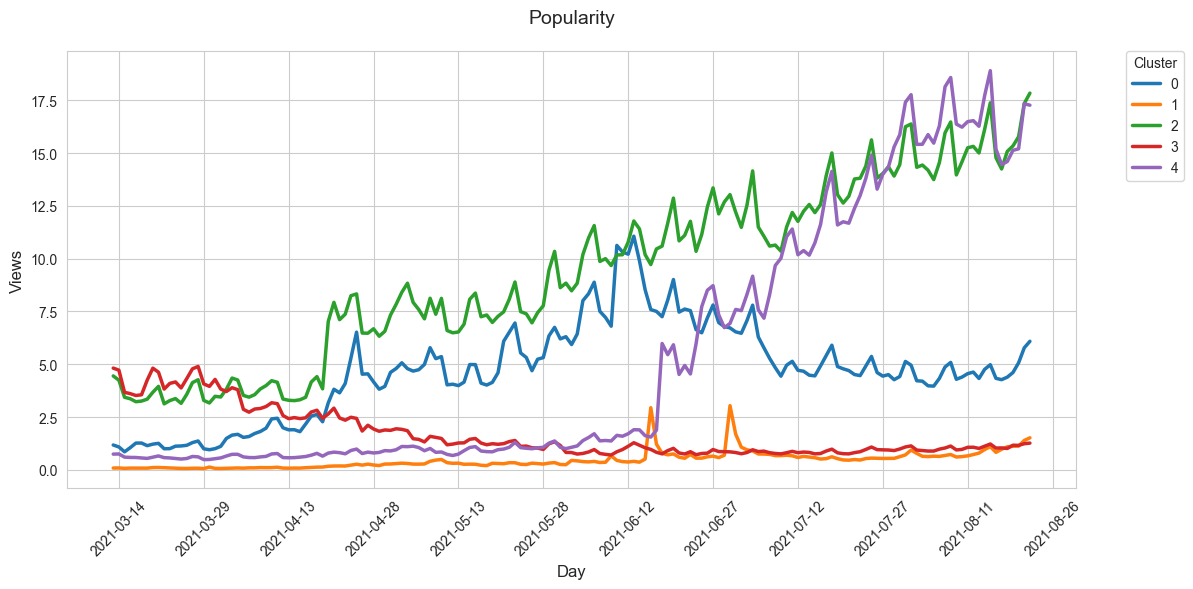

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


centroids = []
for cluster_id in range(5):

    cluster_data = movies_popularity_by_day[movies_popularity_by_day['cluster'] == \
                                             cluster_id].drop('cluster', axis=1)
    centroids.append(cluster_data.mean())


centroid_df = pd.DataFrame(centroids).reset_index()
centroid_df = centroid_df.rename(columns={'index': 'Cluster'})
centroid_df = centroid_df.melt(id_vars='Cluster', var_name='Day', value_name='Average Watches')


plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")


ax = sns.lineplot(
    data=centroid_df,
    x='Day',
    y='Average Watches',
    hue='Cluster',
    palette= sns.color_palette("tab10", n_colors=5),
    linewidth=2.5,
    markersize=8
)

plt.title('Popularity', fontsize=14, pad=20)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Views', fontsize=12)
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(plt.MaxNLocator(15)) 

plt.legend(
    title='Cluster',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=True
)

plt.tight_layout()
plt.show()

Ну, что-то около-описываемое получилось, ща придумаем)

1. Кластер 1 представляет собой средненькие фильмы, где виден эффект 'сарафанного радио' В начале люди (благодаря рекламе или еще чему-то) начинают смотреть их, потом примерно через месяц-2 рассказов, начинают смотреть их знакомые и фильм доходит до пика популярности и популярность сходит.

2. Кластер 2 представляет собой старые фильмы, которые уже потеряли свою популярность и смотрятся только в дни их выхода (мб на сайте рекламят их юбилей)

3. Кластер 3 представляет из себя хайпанувшие фильмы, которые быстро набрали популярность после выхода

4. кластер 4 предсатвляет из себя кино-провалы, немного просмотров вначале и быстрый сход на около-0 популярность. Возможно там уже алгоритмы рекомендаций их задвинули))

5. Тут представлены культовые фильмы, которые были недоступны какое-то время (популярность около 0) но потом сайт смог добавить их в фильмотеку и они сразу же взлетели в просмотрах.

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках. 

In [ ]:
def filter_column(df, column_to_filter,  min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    value_counts = df[column_to_filter].value_counts()
    filtered = df[df[column_to_filter].isin(value_counts[value_counts >= min_freq].index)]
    return filtered

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    res = df.copy()
    while True:
        size = res.shape
        for column in cols:
            res= filter_column(res, column, min_freq)
        if res.shape == size:
            break
    return res

filtered_train = filter_dataframe(df, ['user_id', 'item_id'])

In [54]:
def df_encode(df):
    item2id = {k: v for v, k in enumerate(df.item_id.unique())}
    user2id = {k: v for v, k in enumerate(df.user_id.unique())}

    id2item = {k: v for v, k in item2id.items()}
    id2user = {k: v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df


filtered_train = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
5293774,62924,794,29,20808,100.0
1365094,1019,202,139,4155,64.0
4202548,141335,2361,123,8213,100.0
3963656,172758,32,151,49903,80.0
4165249,174292,92,89,6,0.0


In [55]:
from scipy import sparse as sps

#предполагаю что это то что хотели авторы в user2id + item2id
item2id = {k: v for v, k in enumerate(df.item_id.unique())}
user2id = {k: v for v, k in enumerate(df.user_id.unique())}
id2item = {k: v for v, k in item2id.items()}
id2user = {k: v for v, k in user2id.items()}
matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<962179x15706 sparse matrix of type '<class 'numpy.float64'>'
	with 4278492 stored elements in COOrdinate format>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра. 

In [57]:
def analyze_interaction_thresholds(df, cols=['user_id', 'item_id'], frequencies=range(1, 11)):

    data = [(min_freq, 
             filter_dataframe(df, cols, min_freq)['user_id'].nunique(), 
             filter_dataframe(df, cols, min_freq)['item_id'].nunique()) 
            for min_freq in frequencies]
    

    plot_df = pd.DataFrame(data, columns=['min_freq', 'users', 'items']).melt('min_freq')
    sns.lineplot(data=plot_df, x='min_freq', y='value', hue='variable', 
                 style='variable', markers=True).set(title='Interaction Threshold Analysis')
    plt.gcf().set_size_inches(10, 6)
    plt.grid(True)
    plt.show()

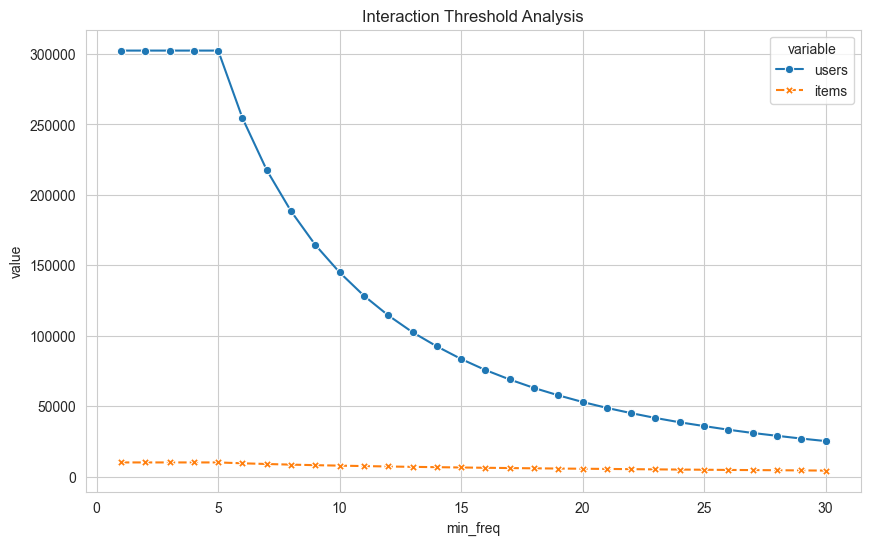

In [59]:
analyze_interaction_thresholds(filtered_train, frequencies=range(1, 31))

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k. 

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [60]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=1000):
    G = X.T @ X
    G += reg_weight * sps.identity(G.shape[0])
    G = G.todense()
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    np.fill_diagonal(B, 0.)
    return B


w = fit_ease(matrix)

CPU times: total: 5min 21s
Wall time: 58.6 s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [67]:
import numpy as np
import scipy.sparse as sps

def get_preds(x, item2id, id2item, w):
    valid = {item2id[t[0]] for t in x if t[0] in item2id}
    vec = sps.csr_matrix(([1]*len(valid), ([0]*len(valid), list(valid))), 
                        shape=(1, w.shape[0]))
    preds = vec.dot(w).A[0]
    preds[list(valid)] = -np.inf
    return [id2item[i] for i in np.argsort(-preds)[:100] if i in id2item]


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,ease_preds
0,382,"[(1112, 89), (565, 129), (10605, 131), (5411, ...","[(11047, 153)]","[16498, 6922, 14112]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[9851, 10746, 1844, 15947, 7626, 16183, 9728, ..."
1,400,"[(169, 144), (11047, 145), (12974, 145), (1399...","[(7793, 153)]","[16498, 6922, 14112]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[8379, 12495, 7626, 7417, 10607, 9100, 13438, ..."
2,414,"[(10440, 152), (2940, 152)]","[(10100, 153), (4143, 153), (9873, 153), (142,...","[16498, 6922, 14112]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[8379, 12495, 1844, 7476, 805, 4566, 9550, 619..."
3,415,"[(3734, 105), (7571, 108), (8442, 110), (4457,...","[(12527, 154), (5330, 162), (16152, 162), (103...","[16498, 6922, 14112]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[12558, 13582, 8849, 2910, 7308, 9352, 11367, ..."
4,467,"[(8077, 21), (7134, 27), (10183, 30), (13955, ...","[(5940, 155), (11155, 159), (3777, 160), (575,...","[16498, 6922, 14112]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[11367, 15947, 13018, 496, 15373, 13582, 6979,..."


In [68]:
evaluate_recommender(joined, model_preds='ease_preds')

{'map': 0.005114176598732967, 'mrr': 0.013148872448540419, 'hr': 0.1656}

In [64]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06570008060909549, 'mrr': 0.11914634920634921, 'hr': 0.2736}

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:** TopPopular лучше в совокупности метрик

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации. 

In [70]:
reg_weights = np.logspace(1, 5, num=20)
for reg_weight in tqdm(reg_weights):
    weights = fit_ease(matrix, reg_weight=reg_weight)
    col_name = f'ease_preds_at_{reg_weight:.1f}'
    joined[col_name] = joined.train_interactions.apply(
        lambda x: get_preds(x, item2id, id2item, weights)
    )

map_scores, hr_scores, mrr_scores, reg_values = [], [], [], []

for reg_weight in reg_weights:
    metric_key = f'ease_preds_at_{reg_weight:.1f}'
    metrics = evaluate_recommender(joined, metric_key)
    reg_values.append(reg_weight)
    map_scores.append(metrics['map'])
    mrr_scores.append(metrics['mrr'])
    hr_scores.append(metrics['hr'])

  0%|          | 0/20 [00:00<?, ?it/s]

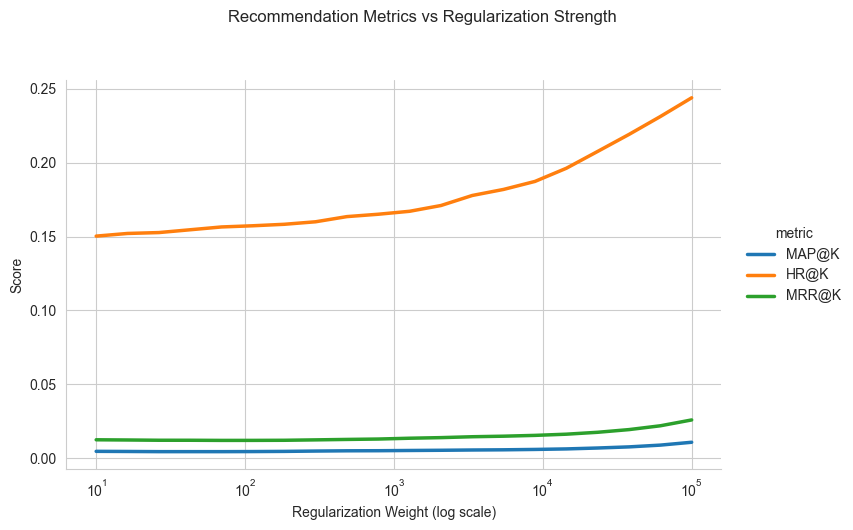

In [71]:
metrics_df = pd.DataFrame({
    'reg_weight': reg_values,
    'MAP@K': map_scores,
    'HR@K': hr_scores,
    'MRR@K': mrr_scores
}).melt(id_vars='reg_weight', var_name='metric', value_name='score')

g = sns.relplot(
    data=metrics_df,
    x='reg_weight',
    y='score',
    hue='metric',
    kind='line',
    height=5,
    aspect=1.5,
    palette='tab10',
    linewidth=2.5
)

g.set(xscale='log', 
      xlabel='Regularization Weight (log scale)', 
      ylabel='Score')
g.fig.suptitle('Recommendation Metrics vs Regularization Strength', y=1.05)
g.tight_layout()
plt.show()

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим? 


**Ответ:** что интересно - наибольшее)

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:** интересен большой рост качества с увеличением параметра, который происходит в конце. Интересно было бы посмотреть что произойдет дальше)

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы. 

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:**

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций. 

In [ ]:
# your code here

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**